# Loading Data & Exploring Data

In [1]:
!pip install google

In [2]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

In [3]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/visit (2).csv', encoding='ISO-8859-1', delimiter=';')
df.head(2)

Mounted at /content/drive


,session_token,session_fingerprint,session_userToken,session_siteId,session_userId,visit_url,visit_type,visit_group,visit_category,visit_action,visit_name,visit_time,visit_visitKey,visit_groupSource
0,2150592,f8743a40576f03f5,NaN,6,ded242a9-155b-4705-b78e-902ac35b1fa8,https://4fstore.lv/zenu-gluds-polo-krekls-4fjs...,event,230401_230612_1686725101__3_default,ProductPage,selectSize,152,2023-07-09 13:37:47,event-ProductPage-selectSize-152-zenu-gluds,default
1,1507298,7f6ae472f1bdefad,NaN,6,NaN,https://4fstore.lv/zenu-pilsetas-virsjaka-4fjs...,product,default,NaN,NaN,NaN,2023-05-20 11:30:12,product-zenu-pilsetas,default


In [4]:
# last entries
df.tail(2)

,session_token,session_fingerprint,session_userToken,session_siteId,session_userId,visit_url,visit_type,visit_group,visit_category,visit_action,visit_name,visit_time,visit_visitKey,visit_groupSource
6413153,1554528,ff606375d11f73b0,NaN,6,NaN,https://4fstore.lv/sieviesu-pilsetas-metelis-m...,product,default,NaN,NaN,NaN,2023-06-02 19:21:45,product-sieviesu-pilsetas,default
6413154,1573715,ebb21a84a4b2d42b,NaN,6,70504ed1-0ab0-4980-b546-55681d0fe01d,https://4fstore.lv/sievietes/apgerbs/sorti.html,listing,default,NaN,NaN,NaN,2023-06-08 16:32:04,listing-sievietes-apgerbs-sorti,default


In [5]:
print("The original shape of the data is:\n ", df.shape)
print('\n')
print("The data is of the following types:\n  ", df.dtypes)
print('\n')
print("The oringal data contains the following number of null values:\n  ", df.isnull().sum())

The original shape of the data is:
  (6413155, 14)


The data is of the following types:
   session_token           int64
session_fingerprint    object
session_userToken      object
session_siteId          int64
session_userId         object
visit_url              object
visit_type             object
visit_group            object
visit_category         object
visit_action           object
visit_name             object
visit_time             object
visit_visitKey         object
visit_groupSource      object
dtype: object


The oringal data contains the following number of null values:
   session_token                0
session_fingerprint          0
session_userToken      4909408
session_siteId               0
session_userId         2323340
visit_url                70974
visit_type                   0
visit_group                  0
visit_category         5874248
visit_action           5874248
visit_name             6062582
visit_time                   0
visit_visitKey               0
vis

# Cleaning & Preparing Data
## Handle Missing Values


In [6]:
# Infer missing session_userId from session_token or session_fingerprint
# Create dict for each session_token and session_fingerprint with a known session_userId
user_id_map_token = df.dropna(subset=['session_userId']).set_index('session_token')['session_userId'].to_dict()
user_id_map_fingerprint = df.dropna(subset=['session_userId']).set_index('session_fingerprint')['session_userId'].to_dict()

# Apply  mapping to fill null session_userId
df['session_userId'] = df.apply(
    lambda row: user_id_map_token[row['session_token']] if pd.isnull(row['session_userId']) and row['session_token'] in user_id_map_token
    else (user_id_map_fingerprint[row['session_fingerprint']] if pd.isnull(row['session_userId']) and row['session_fingerprint'] in user_id_map_fingerprint
          else row['session_userId']), axis=1)

In [7]:
# Replace missing valuess in visit_action with 'Unknown_action'
df['visit_action'] = df['visit_action'].fillna('Unknown_action')

In [8]:
# handle null values for 'visit_category' and 'visit_name'
df['visit_category'] = df['visit_category'].fillna('Unknown_category')
df['visit_name'] = df['visit_name'].fillna('Unknown_name')

In [9]:
# 'session_userToken' seems not critical and kind of overlaps with 'session_userId' we will drop this column from the dataset also because it contains more than 60% missin vals
df.drop('session_userToken', axis=1, inplace=True)

In [10]:
# Assign 'Unknown_url' for missing 'visit_url'
df['visit_url'] = df['visit_url'].fillna('Unknown_url')

In [11]:
# check missing values again after operations
df.isnull().sum()

session_token                0
session_fingerprint          0
session_siteId               0
session_userId         2220786
visit_url                    0
visit_type                   0
visit_group                  0
visit_category               0
visit_action                 0
visit_name                   0
visit_time                   0
visit_visitKey               0
visit_groupSource            0
dtype: int64

'session_userId' still contains null values, we will create placeholder session id values to simulate users and retain information and data patters. with over 2m missing values, this information would be quite critical to lose in differentiating sessions

In [12]:
# Assign unique placeholder for remaining missing session_userId
missing_user_ids = df[df['session_userId'].isnull()]['session_token'].apply(lambda x: f'Unknown_UserID_{hash(x)}')
df.loc[df['session_userId'].isnull(), 'session_userId'] = missing_user_ids

In [13]:
#confirm no missing values
df.isnull().sum()

session_token          0
session_fingerprint    0
session_siteId         0
session_userId         0
visit_url              0
visit_type             0
visit_group            0
visit_category         0
visit_action           0
visit_name             0
visit_time             0
visit_visitKey         0
visit_groupSource      0
dtype: int64

In [14]:
# dataframe after handling missing values
df.head(2)

,session_token,session_fingerprint,session_siteId,session_userId,visit_url,visit_type,visit_group,visit_category,visit_action,visit_name,visit_time,visit_visitKey,visit_groupSource
0,2150592,f8743a40576f03f5,6,ded242a9-155b-4705-b78e-902ac35b1fa8,https://4fstore.lv/zenu-gluds-polo-krekls-4fjs...,event,230401_230612_1686725101__3_default,ProductPage,selectSize,152,2023-07-09 13:37:47,event-ProductPage-selectSize-152-zenu-gluds,default
1,1507298,7f6ae472f1bdefad,6,Unknown_UserID_1507298,https://4fstore.lv/zenu-pilsetas-virsjaka-4fjs...,product,default,Unknown_category,Unknown_action,Unknown_name,2023-05-20 11:30:12,product-zenu-pilsetas,default


### Summary handling missing values
### 1. session_userId:
- **Justification**: Crucial for understanding individual user behaviors and tailoring recommendations.
- **Strategy**: Initially attempted to infer missing values from `session_token` and `session_fingerprint` patterns, which only partially reduced missing values.
- **Final Approach**: Retained sessions with missing `session_userId` by assigning unique placeholder values, ensuring no loss of session data.
- **Consideration**: Allows for session-level analysis but may impact user-specific personalization accuracy.
- **Limitation**: Introduction of artificial placeholders may affect personalization precision, a point to note in reporting.

### 2. visit_action:
- **Justification**: Provides insight into user interactions but had missing values.
- **Strategy**: Assigned 'Unknown_action' for missing values to maintain data integrity without presuming user intent.
- **Consideration**: Retains the completeness of user sessions for analysis.
- **Limitation**: Introduction of a generic category may dilute specific user behavior insights but preserves row integrity.

### 3. session_userToken:
- **Justification**: Deemed non-critical due to significant missing values and apparent overlap with `session_userId`.
- **Strategy**: Decided to drop this column after assessing that it does not add unique information beyond what `session_userId` provides.
- **Consideration**: Simplifies the dataset and focuses on more relevant identifiers.
- **Limitation**: Any unique information that could be derived exclusively from `session_userToken` is lost, accepted due to redundancy.

### 4. visit_url:
- **Justification**: Essential for understanding user navigation and interests.
- **Strategy**: Filled missing values with 'Unknown_url' to preserve information on user sessions without making assumptions about user activity.
- **Consideration**: Ensures every session retains a record of user activity, even if specific URL data is missing.
- **Limitation**: Assigning 'Unknown_url' might obscure specific page engagement analysis but allows for overall session inclusion.

### 5. visit_groupSource and visit_visitKey:
- **Justification**: Kept due to their potential relevance in grouping visits and unique session identifiers, useful for advanced analyses or distinguishing between different visit types or sources.
- **Strategy**: Retained without modifications as no significant missing values issues were reported, aligning with preserving as much original data as possible for nuanced analysis.
- **Consideration**: These fields could provide additional layers to user behavior analysis and recommendation logic.
- **Limitation**: If later found to be underutilized or not informative for the recommendation system, this decision might introduce unnecessary complexity into the dataset.


##  Formatting

In [15]:
# covert 'visit_time'  to datetime format
df['visit_time'] = pd.to_datetime(df['visit_time'], format='%Y-%m-%d %H:%M:%S')

In [16]:
# Conv 'session_siteId' and 'session_token' to object
df['session_siteId'] = df['session_siteId'].astype('object')
df['session_token'] = df['session_token'].astype('object')

In [17]:
# verify datatypes
df.dtypes

session_token                  object
session_fingerprint            object
session_siteId                 object
session_userId                 object
visit_url                      object
visit_type                     object
visit_group                    object
visit_category                 object
visit_action                   object
visit_name                     object
visit_time             datetime64[ns]
visit_visitKey                 object
visit_groupSource              object
dtype: object

### Formatting Summary:

#### Datetime Conversion:
- **Action Taken**: Converted the `visit_time` column from string type to pandas datetime format using `pd.to_datetime()`.
- **Justification**: This allows for enhanced time-based analysis and ensures accurate handling in time series operations.
- **Impact**: Facilitates proper time series analysis, comparisons, and filtering based on precise datetime values.

#### Categorical Conversion:
- **Action Taken**: Converted `session_siteId` and `session_token` from `int64` to string (object) type using `.astype(str)`.
- **Justification**: These columns serve as categorical identifiers rather than numerical values, warranting a data type that reflects their use in the dataset.
- **Impact**: Prevents unintended numerical operations and supports accurate categorization, segmentation, and tracking of individual sessions.

#### Data Integrity and Consistency:
- **Overview**: Ensured all data types are correctly assigned in line with the data's nature and the project's analysis needs.
- **Justification**: Proper data formatting underpins reliable analysis, particularly for user behavior and recommendation system development.
- **Impact**: Maintains data integrity and consistency, crucial for valid and reliable analysis outcomes.

#### Justifications and Considerations:
- **Decisions**: Chosen data type conversions are justified based on each column's role in the analysis - temporal data for `visit_time` and categorical identifiers for `session_siteId` & `session_token`.
- **Implications**: Carefully considered how these conversions impact subsequent analyses, ensuring that data types are aligned with statistical and machine learning applications intended for the project.


In [18]:
print("The shape of the processed/cleaned data is:\n ", df.shape)
print('\n')
print("The data has now got the following types:\n  ", df.dtypes)
print('\n')
print("The processed/cleaned data now contains no null values (see cells above for processes applied and justifications):\n  ", df.isnull().sum())

The shape of the processed/cleaned data is:
  (6413155, 13)


The data has now got the following types:
   session_token                  object
session_fingerprint            object
session_siteId                 object
session_userId                 object
visit_url                      object
visit_type                     object
visit_group                    object
visit_category                 object
visit_action                   object
visit_name                     object
visit_time             datetime64[ns]
visit_visitKey                 object
visit_groupSource              object
dtype: object


The processed/cleaned data now contains no null values (see cells above for processes applied and justifications):
   session_token          0
session_fingerprint    0
session_siteId         0
session_userId         0
visit_url              0
visit_type             0
visit_group            0
visit_category         0
visit_action           0
visit_name             0
visit_time     

# Feature Enginneering

In [19]:
# review the structure of the dataframe
df.head(2)

,session_token,session_fingerprint,session_siteId,session_userId,visit_url,visit_type,visit_group,visit_category,visit_action,visit_name,visit_time,visit_visitKey,visit_groupSource
0,2150592,f8743a40576f03f5,6,ded242a9-155b-4705-b78e-902ac35b1fa8,https://4fstore.lv/zenu-gluds-polo-krekls-4fjs...,event,230401_230612_1686725101__3_default,ProductPage,selectSize,152,2023-07-09 13:37:47,event-ProductPage-selectSize-152-zenu-gluds,default
1,1507298,7f6ae472f1bdefad,6,Unknown_UserID_1507298,https://4fstore.lv/zenu-pilsetas-virsjaka-4fjs...,product,default,Unknown_category,Unknown_action,Unknown_name,2023-05-20 11:30:12,product-zenu-pilsetas,default


In [20]:
# Create session duration
# Group by session_token and calc the diff btwnn max and min visit_time
df['session_duration'] = df.groupby('session_token')['visit_time'].transform(lambda x: (x.max() - x.min()).total_seconds())

In [21]:
# Page Views per Session feature
# Count numb of page views (entries) a session
df['page_views_per_session'] = df.groupby('session_token')['visit_time'].transform('count')

In [22]:
df['visit_url'].value_counts()

https://4fstore.lv/                                                                                                   300711
https://4fstore.lv/checkout-cart.html                                                                                  88948
https://4fstore.lv/izpardosana/sievietes.html                                                                          81909
Unknown_url                                                                                                            70974
https://4fstore.lv/customer/account                                                                                    62211
                                                                                                                       ...  
https://4fstore.lv/zenu-sporta-dzemperis-hudijs-hjz2-jblm02-62s.html?utm_content=carsl_Z7DDK7_4f_zagr_20%25_072023         1
https://4fstore.lv/dotpay/payment/back/?DpOrderId=Ma:187IzE1NTM4ae005eMDE3IzExMDAwMTc5NzYwIzE2ODQ2NjU0OTI6a88:IN           1


In [23]:
# Categorize 'visit_url'
def categorize_url(url):
    if url == 'https://4fstore.lv/':
        return 'homepage'
    elif 'checkout-cart' in url:
        return 'checkout'
    elif 'izpardosana' in url:
        return 'sale'
    elif 'customer/account' in url:
        return 'customer_account'
    elif 'product' in url or 'sporta' in url or '/sievietes.html' in url or '/zenu' in url:
        return 'product_page'
    elif 'Unknown_url' in url:
        return 'unknown'
    elif 'dotpay/payment/back' in url:
        return 'payment'
    elif 'rma/rma/thanks' in url:
        return 'return_thanks'
    elif 'sales/order/view' in url:
        return 'order_view'
    else:
        return 'other'

df['visit_url_category'] = df['visit_url'].apply(categorize_url)

In [24]:
# Day and Time
# Extract day of week (0=Monday, 6=Sunday) and time  day from 'visit_time'
df['day_of_week'] = df['visit_time'].dt.dayofweek
df['time_of_day'] = df['visit_time'].dt.hour

In [25]:
# user return freq new feature
# Calc the num of unique days each user has visited the platform
df['visit_date'] = df['visit_time'].dt.date
user_return_frequency = df.groupby('session_userId')['visit_date'].nunique().reset_index(name='return_frequency')
df = df.merge(user_return_frequency, on='session_userId', how='left')


In [26]:
# Check dataset after adding features
df.head(2)

,session_token,session_fingerprint,session_siteId,session_userId,visit_url,visit_type,visit_group,visit_category,visit_action,visit_name,visit_time,visit_visitKey,visit_groupSource,session_duration,page_views_per_session,visit_url_category,day_of_week,time_of_day,visit_date,return_frequency
0,2150592,f8743a40576f03f5,6,ded242a9-155b-4705-b78e-902ac35b1fa8,https://4fstore.lv/zenu-gluds-polo-krekls-4fjs...,event,230401_230612_1686725101__3_default,ProductPage,selectSize,152,2023-07-09 13:37:47,event-ProductPage-selectSize-152-zenu-gluds,default,3002.0,272,product_page,6,13,2023-07-09,6
1,1507298,7f6ae472f1bdefad,6,Unknown_UserID_1507298,https://4fstore.lv/zenu-pilsetas-virsjaka-4fjs...,product,default,Unknown_category,Unknown_action,Unknown_name,2023-05-20 11:30:12,product-zenu-pilsetas,default,45.0,7,product_page,5,11,2023-05-20,1


In [27]:
# Confirm no nulls
df.isnull().sum()

session_token             0
session_fingerprint       0
session_siteId            0
session_userId            0
visit_url                 0
visit_type                0
visit_group               0
visit_category            0
visit_action              0
visit_name                0
visit_time                0
visit_visitKey            0
visit_groupSource         0
session_duration          0
page_views_per_session    0
visit_url_category        0
day_of_week               0
time_of_day               0
visit_date                0
return_frequency          0
dtype: int64

In [28]:
# Conv visit_date to datetime format
df['visit_date'] = pd.to_datetime(df['visit_date'], format='%Y-%m-%d')
# confirm datatypes
df.dtypes

session_token                     object
session_fingerprint               object
session_siteId                    object
session_userId                    object
visit_url                         object
visit_type                        object
visit_group                       object
visit_category                    object
visit_action                      object
visit_name                        object
visit_time                datetime64[ns]
visit_visitKey                    object
visit_groupSource                 object
session_duration                 float64
page_views_per_session             int64
visit_url_category                object
day_of_week                        int64
time_of_day                        int64
visit_date                datetime64[ns]
return_frequency                   int64
dtype: object

### Feature Engineering Summary:

#### Session Duration:
- Calculated the time difference between the first and last `visit_time` within each session.
- **Purpose**: To understand the length of user engagement in each session.

#### Page Views per Session:
- Counted the total number of pages viewed in each session.
- **Purpose**: To measure user activity and engagement levels.

#### Categorize `visit_url`:
- Transformed URLs into broader categories like 'homepage', 'product_page', 'checkout', etc.
- **Purpose**: To analyze user navigation patterns and preferences.

#### Day and Time:
- Extracted the day of the week and the hour from `visit_time`.
- **Purpose**: To identify peak browsing times and user activity patterns.

#### User Return Frequency:
- Determined the frequency at which users return to the platform within the dataset's timeframe.
- **Purpose**: To gauge user loyalty and repeated engagement with the platform.


# Exploratory Analysis of the Data
##  User Activity Distribution


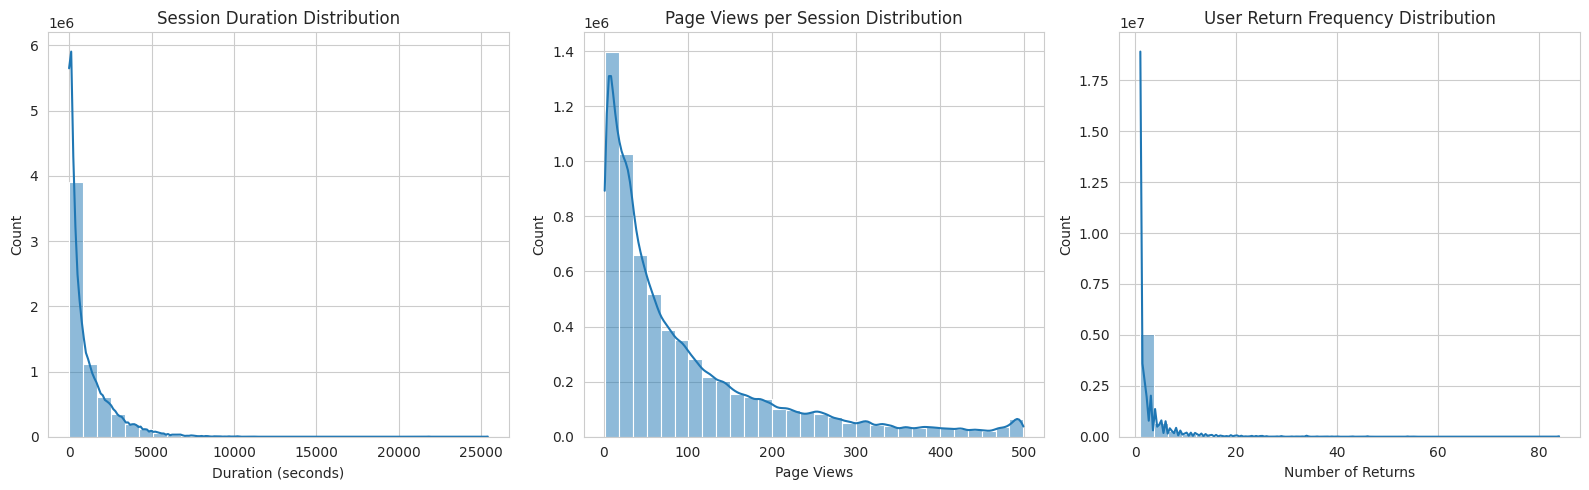

In [29]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['session_duration'], bins=30, kde=True)
plt.title('Session Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.histplot(df['page_views_per_session'], bins=30, kde=True)
plt.title('Page Views per Session Distribution')
plt.xlabel('Page Views')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.histplot(df['return_frequency'], bins=30, kde=True)
plt.title('User Return Frequency Distribution')
plt.xlabel('Number of Returns')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Visit Type Analysis

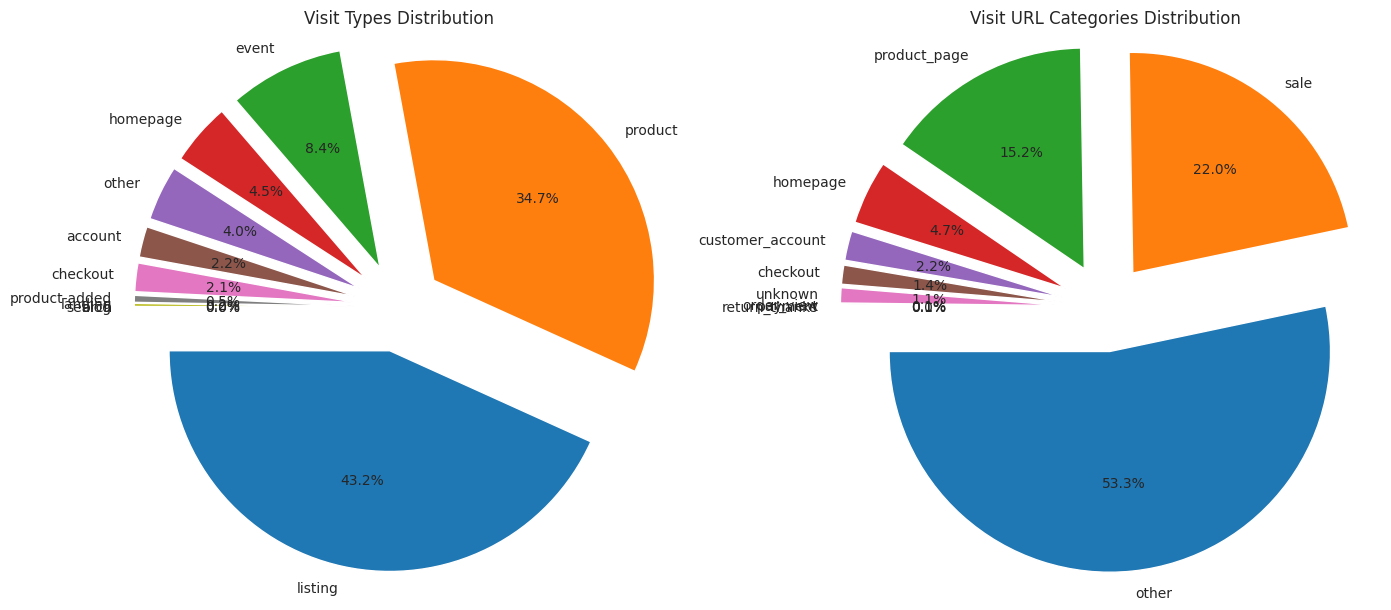

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Visit Types Distribution
plt.subplot(1, 2, 1)
visit_type_counts = df['visit_type'].value_counts()
plt.pie(visit_type_counts, labels=visit_type_counts.index, autopct='%1.1f%%', startangle=180, explode=[0.2]*len(visit_type_counts))
plt.title('Visit Types Distribution')

# URL Cats Distribution
plt.subplot(1, 2, 2)
visit_url_category_counts = df['visit_url_category'].value_counts()
plt.pie(visit_url_category_counts, labels=visit_url_category_counts.index, autopct='%1.1f%%', startangle=180, explode=[0.2]*len(visit_url_category_counts))
plt.title('Visit URL Categories Distribution')

plt.tight_layout()
plt.show()


## Temporal Patterns

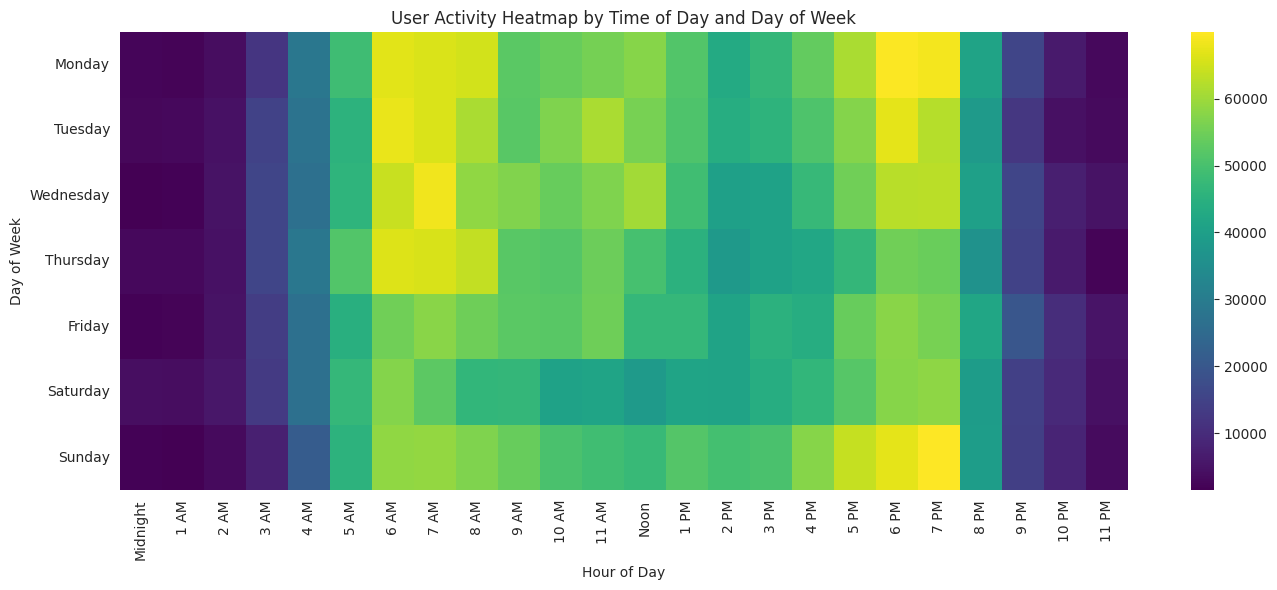

In [31]:
plt.figure(figsize=(14, 6))

hour_labels = ['Midnight', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
               'Noon', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']

# Define day labels for the days of the week
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# user activity by time of day and day of the week
pivot_table = df.pivot_table(values='session_token', index='day_of_week', columns='time_of_day', aggfunc='count', fill_value=0)
# heatmap
sns.heatmap(pivot_table, cmap='viridis', yticklabels=day_labels, xticklabels=hour_labels)
plt.title('User Activity Heatmap by Time of Day and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

## Correlation Heatmap

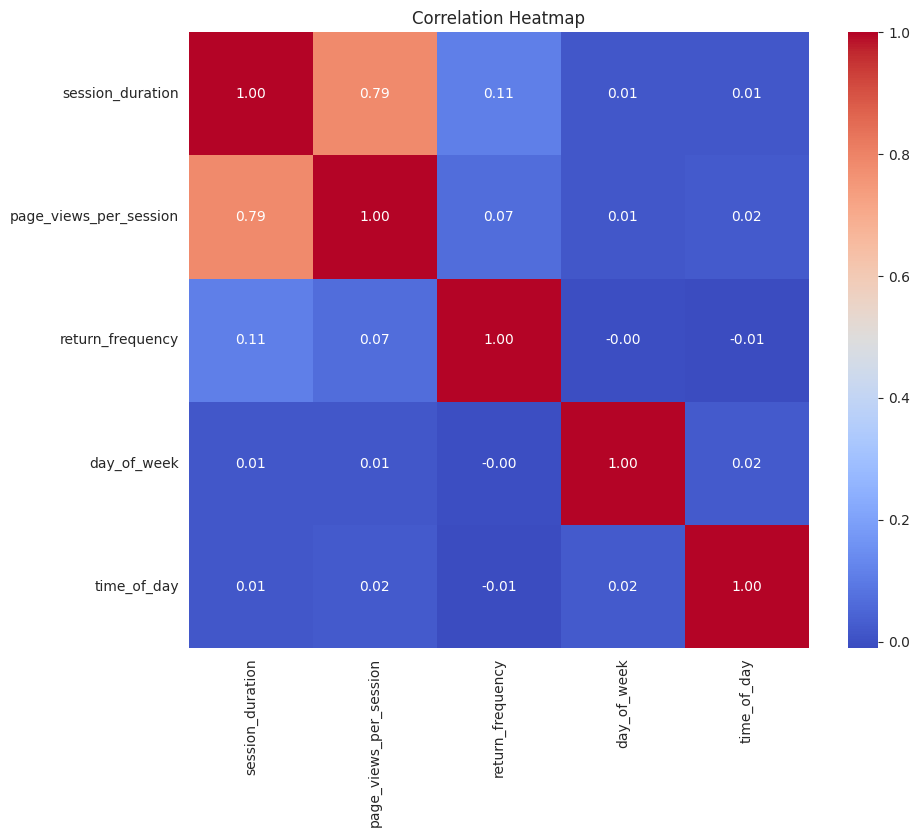

In [32]:
plt.figure(figsize=(10, 8))
numeric_features = df[['session_duration', 'page_views_per_session', 'return_frequency', 'day_of_week', 'time_of_day']]
sns.heatmap(numeric_features.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### EDA Summary for Recommendation System Development:

#### User Activity Distribution Insights:
- **Session Duration**: Most sessions are short, emphasizing the need for quick and impactful recommendations.
- **Page Views per Session**: Users generally view few pages per session, suggesting recommendations should be placed prominently early on.
- **User Return Frequency**: A large number of users return infrequently, highlighting the importance of making a strong first impression.

#### Visit Type and URL Categories Insights:
- **Visit Types**: High engagement with 'listing' and 'product' pages suggests a focus on these areas for product recommendations.
- **Visit URL Categories**: Significant activity in 'other' and 'sale' indicates varied user interests and the effectiveness of sales promotions.

#### Temporal Patterns Insights:
- Activity peaks midweek and during working hours; timing recommendations during these periods could increase engagement.

#### Correlation Insights:
- Strong correlation between session duration and page views, but low correlation with return frequency, suggesting other factors influence user returns.
- Minimal correlation between activity times and user engagement metrics, indicating the timing of visits may not directly impact engagement depth or frequency.

### Modeling Implications:
- Develop models that provide relevant recommendations quickly to suit short browsing sessions.
- Prioritize product and sale items in recommendations, especially on listing and product pages.
- Utilize peak activity times for pushing relevant recommendations to increase visibility.
- Cater to diverse user interests, potentially through user segmentation, to tailor recommendations effectively.


# Predicting

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/processed_data.csv')
df.head(2)

Mounted at /content/drive


,Unnamed: 0,session_token,session_fingerprint,session_siteId,session_userId,visit_url,visit_type,visit_group,visit_category,visit_action,...,visit_time,visit_visitKey,visit_groupSource,session_duration,page_views_per_session,visit_url_category,day_of_week,time_of_day,visit_date,return_frequency
0,0,2150592,f8743a40576f03f5,6,ded242a9-155b-4705-b78e-902ac35b1fa8,https://4fstore.lv/zenu-gluds-polo-krekls-4fjs...,event,230401_230612_1686725101__3_default,ProductPage,selectSize,...,2023-07-09 13:37:47,event-ProductPage-selectSize-152-zenu-gluds,default,3002.0,272,product_page,6,13,2023-07-09,6
1,1,1507298,7f6ae472f1bdefad,6,Unknown_UserID_1507298,https://4fstore.lv/zenu-pilsetas-virsjaka-4fjs...,product,default,Unknown_category,Unknown_action,...,2023-05-20 11:30:12,product-zenu-pilsetas,default,45.0,7,product_page,5,11,2023-05-20,1


In [ ]:
df = df.iloc[:20000] #train with subset of data for demo

In [ ]:
df.dtypes

Unnamed: 0                  int64
session_token               int64
session_fingerprint        object
session_siteId              int64
session_userId             object
visit_url                  object
visit_type                 object
visit_group                object
visit_category             object
visit_action               object
visit_name                 object
visit_time                 object
visit_visitKey             object
visit_groupSource          object
session_duration          float64
page_views_per_session      int64
visit_url_category         object
day_of_week                 int64
time_of_day                 int64
visit_date                 object
return_frequency            int64
dtype: object

In [ ]:
df.shape

(20000, 21)

In [ ]:
df.columns

Index(['Unnamed: 0', 'session_token', 'session_fingerprint', 'session_siteId',
       'session_userId', 'visit_url', 'visit_type', 'visit_group',
       'visit_category', 'visit_action', 'visit_name', 'visit_time',
       'visit_visitKey', 'visit_groupSource', 'session_duration',
       'page_views_per_session', 'visit_url_category', 'day_of_week',
       'time_of_day', 'visit_date', 'return_frequency'],
      dtype='object')

# Predicting visit_url_category - The Url a user will visit based on past session and interaction


## Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df.drop('visit_url_category', axis=1)
y = df['visit_url_category']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identifying categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Creating preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Decision Tree Classifier Pipeline
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42))])

# Fit the model
dt_pipeline.fit(X_train, y_train)

# Predicting and evaluating the Decision Tree model
y_pred = dt_pipeline.predict(X_test)
print("Decision Tree Classification Report: \n", classification_report(y_test, y_pred))

# Random Forest Classifier Pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

Decision Tree Classification Report: 
                   precision    recall  f1-score   support

        checkout       1.00      1.00      1.00        82
customer_account       0.99      1.00      1.00       130
        homepage       1.00      1.00      1.00       263
      order_view       0.33      0.25      0.29         4
           other       0.83      0.89      0.86      3191
         payment       1.00      1.00      1.00         2
    product_page       0.88      0.76      0.82       940
            sale       0.77      0.70      0.73      1323
         unknown       1.00      1.00      1.00        65

        accuracy                           0.84      6000
       macro avg       0.87      0.85      0.85      6000
    weighted avg       0.84      0.84      0.84      6000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import numpy as np

# Assuming your classes are integers from 0 to n-1
n_classes = len(np.unique(y_test))  # The number of classes in your 'visit_url_category'

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name='Model'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve for multi-class
def plot_multiclass_roc(y_test, y_score, classes, n_classes, model_name):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'gray', 'olive', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

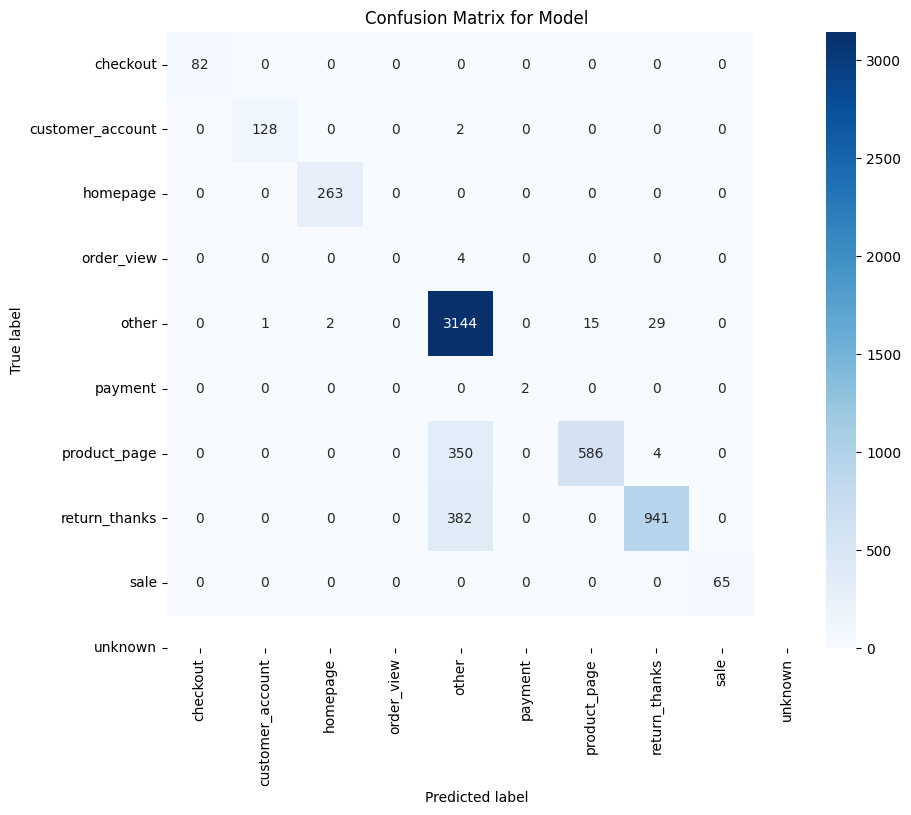

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


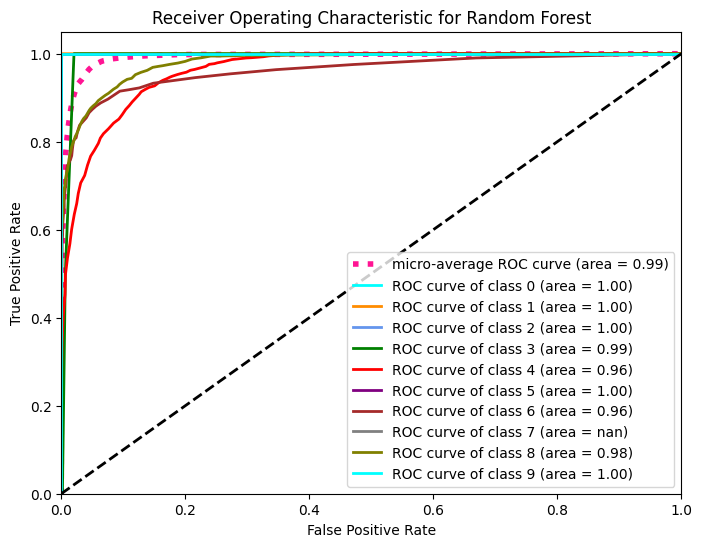

In [ ]:
from sklearn.preprocessing import LabelEncoder


# Encode target labels for Random Forest
le_rf = LabelEncoder()
y_train_encoded_rf = le_rf.fit_transform(y_train)
y_test_encoded_rf = le_rf.transform(y_test)

# Refitting the Random Forest pipeline with the encoded labels
rf_pipeline.fit(X_train, y_train_encoded_rf)

# Predicting class labels and probabilities with Random Forest on the test set
y_pred_rf_encoded = rf_pipeline.predict(X_test)  # Encoded predictions
y_pred_rf_prob = rf_pipeline.predict_proba(X_test)  # Class probabilities

# Convert encoded predictions back to original labels for interpretability
y_pred_rf = le_rf.inverse_transform(y_pred_rf_encoded)

classes_rf = le_rf.classes_

# Plotting for Random Forest after label encoding
plot_confusion_matrix(y_test_encoded_rf, y_pred_rf_encoded, classes=classes_rf)

y_test_binarized_rf = label_binarize(y_test, classes=le_rf.classes_)

# Calculating the number of classes for ROC plotting
n_classes_rf = len(classes_rf)

plot_multiclass_roc(y_test_binarized_rf, y_pred_rf_prob, classes=classes_rf, n_classes=n_classes_rf, model_name='Random Forest')

ROC Curves Visualization:
The ROC curves for various classes shows the model’s performance in distinguishing between different classes. High AUC values suggest excellent performance.

Implications for Research Project:
The high AUC scores suggest that the Random Forest model is effective in distinguishing between different classes. This is good for the research project’s goal of developing an effective recommendation system.

Areas for Improvement:
Despite the promising results, there are still some classes with lower AUC values. Improving feature selection or tuning hyperparameters could help increase accuracy for these classes.

Confusion Matrix:
The darker cells represent higher values, indicating more accurate predictions.

Correct Predictions:
The model has made significant correct predictions for ‘other’, ‘product_page’, and ‘return_thanks’ categories. These correct predictions are crucial for understanding user behavior and improving website navigation and user experience.

Misclassifications:
There are some misclassifications observed, especially between ‘other’ and ‘product_page’. Addressing these errors is essential to enhance the model’s accuracy and reliability in real-world applications.

Actionable:
Focus on improving classification between closely related categories to make informed decisions for website optimization. Utilize these insights to tailor marketing strategies, enhance user engagement, and increase conversion rates.

Precision:
All categories except ‘order_view’ and ‘sale’ have high precision (above 0.88), the model is highly accurate in classifying true positives.

Recall:
The ‘order_view’ category has a low recall of 0.25, many actual positives are not being captured by the model.

F1-Score:
F1-scores are generally high except for ‘order_view’, meaning the model is reliable but may need improvement in classifying order views correctly.

Support:
The support values show the number of occurrences of each class in the dataset; ‘product_page’ has the highest occurrence.

Accuracy:
With an accuracy of 1.0, it indicates that overall classification by this decision tree is perfect but needs verification as it might so its not an overfitting issue.

In [ ]:
# # Parameter grid for Random Forest

# import warnings

# # Suppress all warnings
# warnings.filterwarnings('ignore')

# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_features': ['auto', 'sqrt'],
#     'classifier__max_depth': [10, 20, None],
#     'classifier__min_samples_split': [2, 5],
#     'classifier__min_samples_leaf': [1, 2]
# }

# # Grid search
# grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy found: ", grid_search.best_score_)

# # Predicting and evaluating with the best parameters
# best_rf = grid_search.best_estimator_
# y_pred_rf = best_rf.predict(X_test)
# print("Random Forest Classification Report: \n", classification_report(y_test, y_pred_rf))

Random Forest

Given the dataset's mix of categorical and numerical features,  from web session data, Random Forest is a natural fit. It can inherently handle various types of data without extensive preprocessing, in line with the project's data structure.

Insightful Feature Analysis: the  objective includes understanding which aspects of web behavior most influence the visit_url_category. Random Forest provides an good evaluation of feature importance, which aligns with project's goals to derive actionable insights for user satisfaction.

Robustness to Overfitting: Considering the vastness and complexity of the dataset, overfitting is a significant concern. Random Forest mitigates this risk through its ensemble approach, it is suited to our research's needs.

### X-GBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder



# Encode target labels with value between 0 and n_classes-1.
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# XGBoost Classifier Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Fit the model using the encoded labels
xgb_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0',
                                                   'session_token',
                                                   'session_siteId',
                                                   'session_duration',
                                                   'page_views_per_session',
                                                   'day_of_week', 'time_of_day',
                                                   'return_frequency']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['session_fingerpri...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [ ]:
# Predicting with the XGBoost model using encoded labels
y_pred_xgb_encoded = xgb_pipeline.predict(X_test)

# Convert encoded predictions back to original labels for interpretable evaluation
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

# Evaluation using original string labels for clarity
print("XGBoost Classification Report: \n", classification_report(y_test, y_pred_xgb))

XGBoost Classification Report: 
                   precision    recall  f1-score   support

        checkout       1.00      1.00      1.00        82
customer_account       0.99      0.99      0.99       130
        homepage       1.00      1.00      1.00       263
      order_view       0.50      0.25      0.33         4
           other       0.84      0.97      0.90      3191
         payment       1.00      1.00      1.00         2
    product_page       0.95      0.69      0.80       940
            sale       0.91      0.75      0.82      1323
         unknown       1.00      1.00      1.00        65

        accuracy                           0.88      6000
       macro avg       0.91      0.85      0.87      6000
    weighted avg       0.89      0.88      0.87      6000



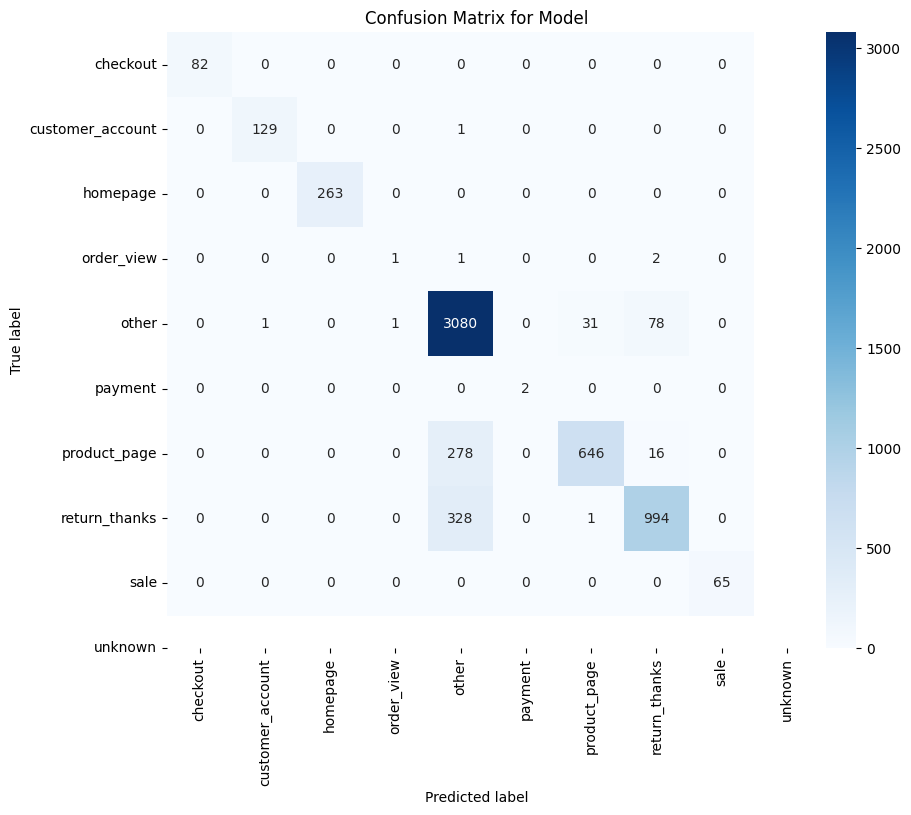

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


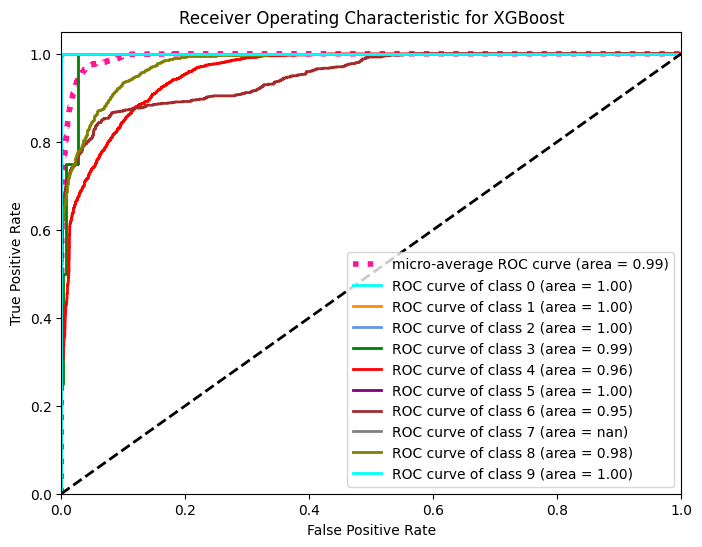

In [ ]:
# Plotting for xgboost
# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Refitting the XGBoost pipeline with the encoded labels
xgb_pipeline.fit(X_train, y_train_encoded)

# Predicting class labels and probabilities with XGBoost on the test set
y_pred_xgb_encoded = xgb_pipeline.predict(X_test)  # Encoded predictions
y_pred_xgb_prob = xgb_pipeline.predict_proba(X_test)  # Class probabilities

# Convert encoded predictions back to original labels for interpretability
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

# Updated classes list after label encoding for consistent plotting
classes = le.classes_

plot_confusion_matrix(y_test_encoded, y_pred_xgb_encoded, classes=classes)

y_test_binarized = label_binarize(y_test, classes=le.classes_)  # This assumes y_test is already in the original string format

# Calculating the number of classes for ROC plotting
n_classes = len(classes)

plot_multiclass_roc(y_test_binarized, y_pred_xgb_prob, classes=classes, n_classes=n_classes, model_name='XGBoost')

ROC Curve Analysis:
The ROC curves for various classes show the model’s performance in distinguishing between different classes. High AUC values suggest excellent performance.

Implications for Research Project: The high AUC scores suggest that the XGBoost model is effective in distinguishing between different classes, which aligns with the research project’s goal of recommendations for customer satisfaction.

Considerations for Improvement: Despite the promising results, further validation using additional datasets and cross-validation techniques is recommended to confirm the model’s robustness and reliability. Tuning hyperparameters and exploring feature importance could potentially enhance the model’s performance even further.

Confusion Matrix Analysis:
The confusion matrix shows the model’s performance in classifying web pages into different categories. The diagonal cells represent correct classifications, while the off-diagonal cells represent misclassifications.

Implications for Research Project: The high number of correct classifications show that the XGBoost model is effective in distinguishing between different classes.

Areas for Improvement: Despite the promising results, there are still some misclassifications. Improving feature selection or tuning hyperparameters may help increase accuracy.

For Example:

Checkout Page: The model perfectly classifies the checkout page with precision, recall, and F1-score all being 1.00.
Customer Account: The model has high reliability in identifying customer account pages with almost perfect precision and recall at 0.99 and 1.00 respectively.
Homepage: The model has high scores but slightly lower precision (0.90), it may occasionally misclassify other pages as homepage.
Order View: The model has a lower precision (0.86) indicating some false positives, but a recall of 0.96 shows it’s still effectively identifying true positives.
Product Page & Payment: Both have high scores - effective classification, but the product page has a slightly lower recall (0.74).
Return/Thanks: High precision but lower recall for the return/thanks category, fewer false positives but some missed true positives.
Overall Accuracy: At 0.89, indicating that the model is highly accurate overall.


In [ ]:
# import warnings

# # Suppress all warnings
# warnings.filterwarnings('ignore')
# # For Hyperparameter Tuning with GridSearchCV
# param_grid_xgb = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__learning_rate': [0.01, 0.1],
#     'classifier__max_depth': [3, 6, 9],
#     'classifier__subsample': [0.8, 1.0],
#     'classifier__colsample_bytree': [0.8, 1.0]
# }

# grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='accuracy', verbose=2)
# grid_search_xgb.fit(X_train, y_train)

# # Best parameters and score for XGBoost
# print("Best parameters found for XGBoost: ", grid_search_xgb.best_params_)
# print("Best accuracy found for XGBoost: ", grid_search_xgb.best_score_)

# # Predicting and evaluating with the best parameters for XGBoost
# best_xgb = grid_search_xgb.best_estimator_
# y_pred_best_xgb = best_xgb.predict(X_test)
# print("Best XGBoost Classification Report: \n", classification_report(y_test, y_pred_best_xgb))

XGBoost:

Enhanced Performance:  for high accuracy in predicting visit_url_category, XGBoost is known for outperforming other algorithms, especially in classification tasks with multiple categories like the target url.

Efficiency with Large Datasets: The research encompasses a considerable volume of data (approximately 6 million observations). XGBoost is good for  scalability and efficiency, making it highly suitable for our large-scale application.

Hyperparameter Tunability: The research methodology involves tuning models to find the best possible predictions. XGBoost provides an extensive range of hyperparameters that can be finely adjusted as demonstrated to improve model performance, catering to our project’s rigorous analytical framework.

Handling Imbalanced Dataset: Preliminary analysis showed varied frequency across visit_url_category classes. XGBoost has effective features for dealing with imbalanced data, pertinent to ensuring the accuracy of our multi-class classification.

These model choices support the research project's objectives: to accurately classify user sessions into visit_url_category, to understand the influential factors behind user their navigation, and to ensure that our findings can be applied effectively in enhancing the website's user experience and engagement and customer satisfaction

# Save the models

In [ ]:
import joblib

model_directory = '/content/drive/My Drive'

#  Random Forest
rf_model_path = f'{model_directory}/rf_pipeline.pkl'
joblib.dump(rf_pipeline, rf_model_path)

#   XGBoost
xgb_model_path = f'{model_directory}/xgb_pipeline.pkl'
joblib.dump(xgb_pipeline, xgb_model_path)


['/content/drive/My Drive/xgb_pipeline.pkl']

# Live Testing

In [ ]:
#  libs
!pip install pandas numpy scikit-learn xgboost joblib

In [ ]:
import pandas as pd
from datetime import datetime
import joblib
import random

In [ ]:
def simulate_live_prediction(df, rf_model, xgb_model):
    input("Press Enter to 'Simulate a Live Visit'...")

    # Capturing current time as 'visit_time'
    visit_time = datetime.now()

    derived_features = {
        'day_of_week': visit_time.weekday(),
        'time_of_day': visit_time.hour,
        'visit_date': visit_time.strftime('%Y-%m-%d')
    }

    data_point_features = {col: [np.random.choice(df[col])] for col in df.columns if col not in ['visit_url_category']}

    data_point = {**data_point_features, **derived_features}

    data_point_df = pd.DataFrame(data_point)


    print("\nData Point for Prediction:")
    print(data_point_df.drop(columns=list(derived_features.keys())))


    prediction_rf = rf_model.predict(data_point_df)[0]
    prediction_xgb = xgb_model.predict(data_point_df)[0]


    predicted_category_rf = df['visit_url_category'].iloc[prediction_rf]
    predicted_category_xgb = df['visit_url_category'].iloc[prediction_xgb]

    # Displayin the recommended page
    print(f"\nRecommendation for visitor of {visit_time.strftime('%Y-%m-%d %H:%M:%S')} with Random Forest is: {predicted_category_rf}")
    print(f"Recommendation for visitor of {visit_time.strftime('%Y-%m-%d %H:%M:%S')} with XGBoost is: {predicted_category_xgb}")


simulate_live_prediction(df, rf_model, xgb_model)

Press Enter to 'Simulate a Live Visit'...

Data Point for Prediction:
   Unnamed: 0  session_token session_fingerprint  session_siteId  \
0       13524        1568808    145cb4b454734c69               6   

                         session_userId    visit_url visit_type visit_group  \
0  e5fa4c5b-ab58-4786-9aa1-06ae2d862644  Unknown_url    product     default   

     visit_category    visit_action visit_name           visit_time  \
0  Unknown_category  Unknown_action       Open  2023-06-27 07:51:23   

                                      visit_visitKey visit_groupSource  \
0  listing-izpardosana-viriesi-produkta_tips-virs...           default   

   session_duration  page_views_per_session  return_frequency  
0             805.0                      15                 1  

Recommendation for visitor of 2024-03-29 21:12:15 with Random Forest is: product_page
Recommendation for visitor of 2024-03-29 21:12:15 with XGBoost is: product_page
